##Alunos: Gabriel e Guilherme

Vizualização dos pesos foi baseado no trabalho da Gabriela Surita

O objetivo deste notebook é visualizar as camadas de atenção cruzada na rede de legendas automáticas usando EfficientNet e T5.

# Setup do ambiente

In [1]:
% pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [2]:
!pip3 install -q --upgrade efficientnet_pytorch  \
                           transformers \
                           pytorch_lightning \
                           sacrebleu \
                           h5py

     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 585 kB 59.9 MB/s 
     |████████████████████████████████| 92 kB 13.2 MB/s 
     |████████████████████████████████| 4.1 MB 45.3 MB/s 
     |████████████████████████████████| 596 kB 71.9 MB/s 
     |████████████████████████████████| 6.6 MB 57.1 MB/s 
     |████████████████████████████████| 101 kB 7.2 MB/s 
     |████████████████████████████████| 140 kB 55.8 MB/s 
     |████████████████████████████████| 419 kB 58.6 MB/s 
     |████████████████████████████████| 1.1 MB 22.8 MB/s 
     |████████████████████████████████| 271 kB 65.9 MB/s 
     |████████████████████████████████| 144 kB 55.9 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 


In [3]:
# Importar todos os pacotes de uma só vez para evitar duplicados ao longo do notebook.
import gzip
import os
import pytorch_lightning as pl
import random
import sacrebleu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import json

from google.colab import drive

from pytorch_lightning.callbacks import ModelCheckpoint

from efficientnet_pytorch import EfficientNet

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from matplotlib import pyplot as plt
import h5py


device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

(2, 'Tesla P100-PCIE-16GB')

In [4]:
from nltk.translate import meteor
from nltk import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Download do Dataset

Download do dataset MS COCO reduzido para 23k exemplos:

In [5]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-07-07 00:57:19--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.002s  

2022-07-07 00:57:19 (116 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json’ saved [289777/289777]

--2022-07-07 00:57:19--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request 

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# pip install neptune-client

In [8]:
# import neptune.new as neptune

# run = neptune.init(
#     project="gabriellopes2006/imagecaption",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1MDQyNDVkOC03NDI5LTQ5YWEtOGFjNC03MTI1YjEyZGRlN2MifQ==",
# )  # your credentials

In [9]:
os.environ['PYTHONHASHSEED'] = '0'
# Important: Fix seeds so we can replicate results
seed_value = 123
torch.manual_seed(seed_value)
seed = np.random.seed(seed_value)

if torch.cuda.is_available():
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1
Tesla P100-PCIE-16GB
cuda:0


O dataset deve conter 23520, 1052 e 1047 imagens de treino, validação e teste.

In [10]:
import random
import json
import h5py

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Normalization suggested by the EfficientNet library when trained with adversarial examples.
# https://github.com/lukemelas/EfficientNet-PyTorch#update-january-23-2020
transform = transforms.Compose([
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])


class CaptioningDataset(Dataset):
    """
    Dataset that loads image instances lazily to memory.
    """

    def __init__(self, img_file, target_file, img_transform=lambda x: x, text_transform=lambda x: x):
        
        # We need to defer loading the images as h5py files cant be forked.
        # Ref: https://github.com/pytorch/pytorch/issues/11929
        self.img_file = img_file
        self.images = None
        
        self.targets = json.load(open(target_file, "r"))

        self.img_transform = img_transform
        self.text_transform = text_transform

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
    
        if not self.images:
            self.images = h5py.File(self.img_file, 'r') 
            
        img = self.images["images"][idx]
        cap = self.targets[idx]

        # Convert to float.
        img = img.astype(float)

        # Normalize image between 0 and 1.
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
                
        return self.img_transform(img), self.text_transform(cap)

    def __del__(self):
        if self.images:
            self.images.close()
    

train_set = CaptioningDataset("./TRAIN_IMAGES_coco_5_cap_per_img.hdf5", "./TRAIN_CAPTIONS_coco_5_cap_per_img.json", img_transform=transform)
val_set = CaptioningDataset("./VAL_IMAGES_coco_5_cap_per_img.hdf5", "./VAL_CAPTIONS_coco_5_cap_per_img.json", img_transform=transform)
test_set = CaptioningDataset("./TEST_IMAGES_coco_5_cap_per_img.hdf5", "./TEST_CAPTIONS_coco_5_cap_per_img.json", img_transform=transform)

In [11]:
'''
A função collate_any seleciona um label aleatório dentre os 5 correspondentes a figura,
e uma vez definido o label realiza-ra o tokenização do mesmo de ocordo com o encoded de
T5. Sendo este usado no Dataset de treino
'''
tokenizer = T5Tokenizer.from_pretrained('t5-small')
# tokenizer = T5Tokenizer.from_pretrained('google/t5-v1_1-base')
# tokenizer = T5Tokenizer.from_pretrained('t5-base')

def collate_any(batch):
   
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = np.array([random.choice(r[1]) for r in batch])
    
    batch_tokens = tokenizer.batch_encode_plus(
        labels,
        padding="longest",
        return_tensors="pt")['input_ids']

    return imgs, labels, batch_tokens

'''
 Um processo semelhante é aplicado pela collate_all, entretanto neste usa-se
 os 5 labels de cada imagem, passando eles pelo tokenizador. Sendo este metodo
 usado para os datasets de validação e teste.
'''
def collate_all(batch):
  
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = np.array([r[1] for r in batch])

    encoded = [tokenizer.batch_encode_plus(label, 
                                           padding="longest", 
                                           return_tensors='pt')['input_ids']
    for label in labels]
            
    return imgs, labels, encoded

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


# Criando Dataloaders para teste de alinhamento

Para isto são definidos a seguir Dataloaders de validação e treino, como os parâmetros abaixo. 

In [12]:
params = {
    'batch_size_train': 4,
    'num_workers': 1,
    'seq_len': 64
}

In [13]:
train_loader = DataLoader(train_set,
                          batch_size=params['batch_size_train'],
                          num_workers=os.cpu_count(),
                          collate_fn=collate_any)

val_loader = DataLoader(val_set,
                        batch_size=params['batch_size_train'],
                        num_workers=os.cpu_count(),
                        collate_fn=collate_all)

# Avaliando o DataLoader Validação

Primeiramente será avaliado o Dataloader de validação gerado, onde este apresenta 5 Labels para cada uma das imagens conforme indicado a seguir:

torch.Size([3, 256, 256])


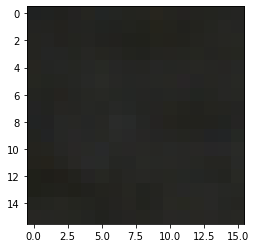

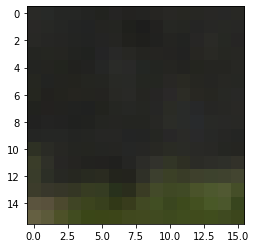

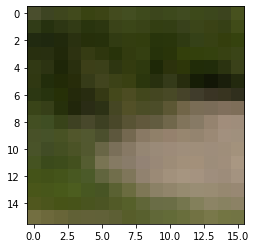

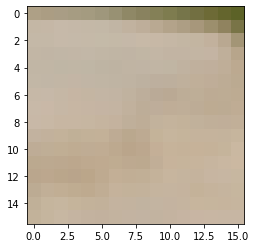

tensor([11874,    16,     3,     9,  5040,   420,  3609,     3,     9, 25573,
           16,   160,   223,  6178,     1])
tensor([  71, 1021, 3202,   19, 3609,    3,    9,  422, 1712,    5,    1,    0,
           0,    0,    0])
tensor([   71,  3202,  3993,     7,    38,   255,  4532,     3,     9,     3,
          157, 17132,  1712,     5,     1])
tensor([11874,    28,     3,     9,  4459,  8677,  3609,     3,     9,   422,
         1712,     1,     0,     0,     0])
tensor([   71,   385,  3202,  3609,     3,     9, 25573,   416,    12,     3,
            9,  1692,  8227,     5,     1])


In [ ]:
# Val loader usa o collate_all e retorna os 5 labels de cada imagem
imgs, tokens,labels = next(iter(val_loader))
for img, label in zip(imgs, labels):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    print(img.shape)
    for i in range(4):
      a = img[:, i*16:(i+1)*16, :16]
      plt.imshow((a.numpy().transpose(1, 2, 0)+1)/2) # adversarial
      plt.show()
    for caption in label:
      print(caption)

    break

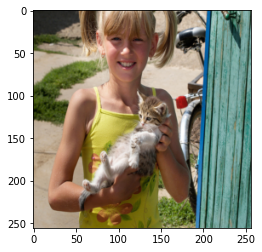

In [62]:
plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
plt.show()

In [ ]:
img.unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [ ]:
patch = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=8, stride=8)
p = patch(img.unsqueeze(0))

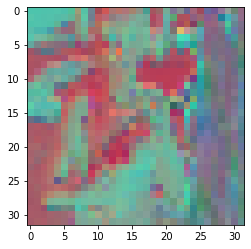

In [ ]:
plt.imshow((p.detach().squeeze().numpy().transpose(1, 2, 0)+1)/2) # adversarial
plt.show()

In [63]:
class ImageCut(nn.Module):
    def __init__(self, height, width, kernel_size, stride):
        super(ImageCut, self).__init__()

        self.kernel_size = kernel_size
        self.stride      = stride
        self.n_height    = height // kernel_size
        self.n_width     = width // kernel_size

    def forward(self, x):
        img = []
        for i in range(0, self.n_height):
            for j in range(0, self.n_width):
            
                img.append(x[:, :, j*self.stride:(j+1)*self.stride, i*self.stride:(i+1)*self.stride])

        return torch.cat(img, 1)


In [66]:
ic = ImageCut(256, 256, 16, 16)
s  = ic(img.unsqueeze(0))

In [67]:
s.shape

torch.Size([1, 768, 16, 16])

In [ ]:
s[0].squeeze().shape

torch.Size([3, 15, 15])

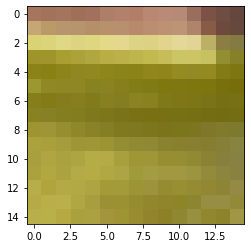

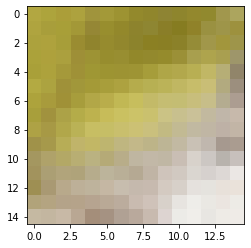

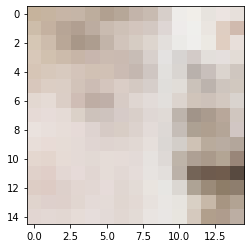

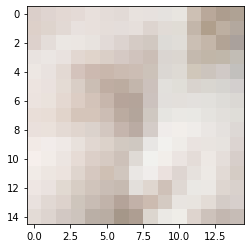

In [ ]:
for i in range(120,124):
    plt.imshow((s[i].squeeze().numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.show()

# Avaliando o DataLoader Treino

A seguir será avaliado o Dataloader de treino gerado, onde este apresenta apenas 1 Label para cada uma das imagens, sendo ele escolhido de forma aleatória dentre os 5 caracteristicos da imagem.

In [ ]:
# imgs, tokens,labels = next(iter(train_loader))
# for img, label in zip(imgs, labels):
#     # Desfazendo a normalização da imagem
#     plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # Normalização da efn adversarial
#     plt.show()
#     print(label)

# Treinando

torch.Size([3, 256, 256])


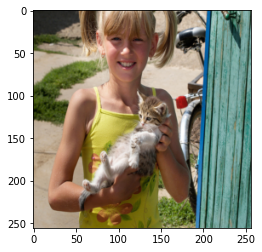

Girl in a tank top holding a kitten in her back yard
A young girl is holding a small cat.
A girl smiles as she holds a kitty cat.
Girl with a yellow shirt holding a small cat
A little girl holding a kitten next to a blue fence.


In [26]:
# Val loader usa o collate_all e retorna os 5 labels de cada imagem
imgs, labels, tokens = next(iter(val_loader))
for img, label in zip(imgs, labels):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    print(img.shape)
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.show()
    for caption in label:
      print(caption)

    break

In [27]:
pe = PatchEmbed(img_size=256, patch_size=4, in_chans=3, embed_dim=768)
pe(img).shape

torch.Size([768, 64, 64])

In [12]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()

        self.img_size   = img_size
        self.patch_size = patch_size
        self.n_patches  = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(x)  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x

In [20]:
class ImageCut(nn.Module):
    def __init__(self, height, width, kernel_size, stride):
        super(ImageCut, self).__init__()

        self.kernel_size = kernel_size
        self.stride      = stride
        self.n_height    = height // kernel_size
        self.n_width     = width // kernel_size

    def forward(self, x):
        img = []
        for i in range(0, self.n_height):
            for j in range(0, self.n_width):
            
                img.append(x[:, :, j*self.stride:(j+1)*self.stride, i*self.stride:(i+1)*self.stride])

        return torch.cat(img, 1)

In [13]:
from nltk.translate.meteor_score import meteor_score

def corpus_meteor(expected, predicted):

    meteor_score_sentences_list = list()
    [meteor_score_sentences_list.append(meteor_score(expect, predict)) for expect, predict in zip(expected, predicted)]
    meteor_score_res = np.mean(meteor_score_sentences_list)
    return meteor_score_res


In [14]:
# With Learnable Parameters
m = nn.BatchNorm2d(100)
# Without Learnable Parameters
m = nn.BatchNorm2d(100, affine=False)
input = torch.randn(20, 100, 35, 45)
output = m(input)
output.max()

tensor(5.5209)

In [14]:
from transformers import AdamW
import nltk


class T5Finetuner(pl.LightningModule):

    def __init__(self, train_dataloader, val_dataloader, test_dataloader, params):
        super(T5Finetuner, self).__init__()

        self.params = params
        
        self._train_dataloader = train_dataloader
        self._val_dataloader   = val_dataloader
        self._test_dataloader  = test_dataloader

        # Features da efficient net atuarão como as features do encoder do T5
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['model_name'])
        # print(self.decoder.config.d_ff)

        '''# Patch convolution. Basically tranform the 2D image into 16x16 patches with 2048 dimensions.
        self.patch = nn.Conv2d(in_channels=3, out_channels=self.decoder.config.d_ff, kernel_size=8, stride=8)

        # Convert patches from 2048 to 512 dimensions.
        self.linear = nn.Linear(self.decoder.config.d_ff, self.decoder.config.d_model)'''

        dim = self.decoder.config.d_model if self.decoder.config.d_model % 2 == 0 else self.decoder.config.d_model + 1
        print(dim, type(dim))

        # self.norm = nn.BatchNorm2d(3)

        # self.pe = PatchEmbed(img_size=256, patch_size=8, in_chans=3, embed_dim=512)
        self.pe = PatchEmbed(img_size=256, patch_size=8, in_chans=3, embed_dim=1024)

        '''self.init_conv = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16,  kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(16),
                                       nn.Dropout(p=0.01),
                                       nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.Dropout(p=0.01),
                                       nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(16),
                                       nn.Dropout(p=0.01),
                                       nn.Conv2d(in_channels=16, out_channels=3,  kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(3))'''
        
        '''self.init_conv = nn.Sequential(nn.Conv2d(in_channels=768, out_channels=512,  kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.Dropout(p=0.01),
                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.Dropout(p=0.01),
                                       nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.Dropout(p=0.01),
                                       nn.Conv2d(in_channels=512, out_channels=768,  kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(768))'''

        # self.patch = ImageCut(256, 256, 16, 16)
        # self.linear = nn.Linear(768, self.decoder.config.d_model)
        # self.linear = nn.Linear(256, self.decoder.config.d_model)

        '''self.linear = nn.Sequential(nn.LayerNorm(768),
                                    nn.Linear(768, 768),
                                    nn.SiLU(),
                                    nn.Linear(768, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 128),
                                    nn.SiLU(),
                                    nn.Linear(128, 128),
                                    nn.SiLU(),
                                    nn.Linear(128, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 768))'''
        
        '''self.linear = nn.Sequential(nn.Linear(256, 768),
                                    nn.SiLU(),
                                    nn.Linear(768, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 128),
                                    nn.SiLU(),
                                    nn.Linear(128, 128),
                                    nn.SiLU(),
                                    nn.Linear(128, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 768),
                                    nn.LayerNorm(768))'''

        '''self.linear = nn.Sequential(nn.LayerNorm(1024),
                                    nn.Linear(1024, 512),
                                    nn.SiLU(),
                                    nn.Linear(512, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 512))'''

        self.linear = nn.Sequential(nn.LayerNorm(1024),
                                    nn.Linear(1024, 512),
                                    nn.SiLU())

        self.tokenizer = T5Tokenizer.from_pretrained(params['model_name'])
        self.learning_rate = params['learning_rate']


    def forward(self, batch):

        images, labels, tokens = batch


        

        # print(x.shape)

        # features = self.pe(self.norm(images))
        # print(features.shape)
        # torch.Size([16, 3072, 32, 32])
        # torch.Size([16, 768, 16, 16])
        # torch.Size([16, 768, 16, 16])

        # features = self.init_conv(features)
        # efn_embeddings = self.pe(self.norm(images))
        efn_embeddings = self.pe(images)

        # efn_embeddings = features.permute(0, 2, 3, 1).reshape(features.shape[0], -1, 768)
        # efn_embeddings = features.permute(0, 1, 2, 3).reshape(features.shape[0], 768, -1)

        # print(efn_embeddings.shape)
        # torch.Size([16, 1024, 3072])
        # torch.Size([16, 2048, 96])
        # torch.Size([16, 256, 768])


        # Add a non-linearity (this seems to speed up training a little bit).
        efn_embeddings = F.relu(efn_embeddings)
        # print(efn_embeddings.shape)
        # torch.Size([16, 1024, 3072])
        # torch.Size([16, 2048, 96])
        # torch.Size([16, 256, 768])


        # mat1 and mat2 shapes cannot be multiplied (32768x96 and 768x512)
        # mat1 and mat2 shapes cannot be multiplied (1536x2048 and 768x512)
        
        # Resize to transformer dimension.
        efn_embeddings = self.linear(efn_embeddings)
        # print(efn_embeddings.shape)
        # torch.Size([16, 1024, 768])
        #
        # torch.Size([16, 256, 512])

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=tokens,
                                   return_dict=True)
            return outputs.loss
        else:
            max_length = self.params['seq_len']

            # Add start of sequence token
            decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                    self.decoder.config.decoder_start_token_id,
                                    dtype=torch.long).to(efn_embeddings.device)

            encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

            for step in range(max_length-1):
                logits = self.decoder(decoder_input_ids=decoded_ids,
                                      encoder_outputs=encoder_hidden_states)[0]
                next_token_logits = logits[:, -1, :]

                # Greedy decoding
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                
                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                    break

                # Concatenate past ids with new id, keeping batch dimension
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

            return decoded_ids

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        # run["train/loss"].log(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):

        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        list_of_references = [[trues[b][i].split() for i in range(len(trues[b]))]for b in range(len(trues))]
        list_of_hypotheses = [preds[b].split() for b in range(len(preds))]

        bleu_scores = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        meteor_scores = corpus_meteor(list_of_references, list_of_hypotheses)

        self.log("val_bleu", torch.tensor(bleu_scores, dtype=torch.float64)*100, prog_bar=True)
        self.log("val_meteor_score", torch.tensor(meteor_scores, dtype=torch.float64)*100, prog_bar=True)

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)
        # run["eval/loss"].log(bleu.precisions[0])
        # run["eval/loss"].log(bleu.precisions[0])
        # run["eval/loss"].log(bleu.precisions[3])
        # run["eval/val_bleu_1"] = bleu.precisions[0]
        # run["eval/val_bleu_4"] = bleu.precisions[3]
        # run["eval/val_bleu_score"] = bleu.score

    def test_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        list_of_references = [[trues[b][i].split() for i in range(len(trues[b]))]for b in range(len(trues))]
        list_of_hypotheses = [preds[b].split() for b in range(len(preds))]

        bleu_scores = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        meteor_scores = corpus_meteor(list_of_references, list_of_hypotheses)

        self.log("test_bleu", torch.tensor(bleu_scores, dtype=torch.float64)*100, prog_bar=True)
        self.log("test_meteor_score", torch.tensor(meteor_scores, dtype=torch.float64)*100, prog_bar=True)


        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # # Sobre como o corpus_bleu interpreta os inputs: 
        # # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))

        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate, eps=1e-08)
        # return AdamW(self.parameters(), lr=5e-4)

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

In [15]:
lr =  5e-4#@param {type: "number"}
bs =    16#@param {type: "integer"} 
patience =  20#@param {type: "integer"}
max_epochs =  100#@param {type: "integer"}
seq_len = 16#@param {type: "integer"}
# Define hyperparameters
params = {
          
          'model_name': 't5-small',
          'batch_size': bs,
          'num_workers': os.cpu_count(),
          'learning_rate': lr,
          'max_epochs': max_epochs, 
          'patience': patience,
          'monitor_variable': 'val_bleu_score',
          'seq_len':seq_len
      }
print(params)

{'model_name': 't5-small', 'batch_size': 16, 'num_workers': 2, 'learning_rate': 0.0005, 'max_epochs': 100, 'patience': 20, 'monitor_variable': 'val_bleu_score', 'seq_len': 16}


In [16]:
# run["parameters"] = params

In [16]:
train_loader = DataLoader(train_set,
                          shuffle=True,
                          batch_size=params['batch_size'],
                          num_workers=params['num_workers'],
                          collate_fn=collate_any)

val_loader = DataLoader(val_set,
                        batch_size=2,
                        num_workers=params['num_workers'],
                        collate_fn=collate_all)

test_loader = DataLoader(test_set,
                         num_workers=params['num_workers'],
                         collate_fn=collate_all)

# Teste do modelo com 1 batch

In [29]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)

512 <class 'int'>


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [22]:
trainer = pl.Trainer(gpus=1, 
                     max_epochs=1,
                     enable_checkpointing=False,  # Disable checkpoint saving.
                     fast_dev_run=True)

trainer.fit(model)
trainer.test(model)
del model  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | pe      | PatchEmbed                 | 98.8 K
2 | linear  | Sequential                 | 263 K 
----------------------------------------------

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk>



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['A large jetliner sitting on top of an airport runway.'
 'View from gate of jet connected to jet way for passengers to board or deplane'
 'Airline employees by an aircraft parked at the gate'
 'A large white airplane and a person on a lot.'
 'The plane is parked at the gate at the airport terminal.']
Prediction: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


Sample Target: ['A large jetliner sitting on top of an airport runway.'
 'View from gate of jet connected to jet way for passengers to board or deplane'
 'Airline employees by an aircraft parked at the gate'
 'A large white airplane and a person on a lot.'
 'The plane is parked at the gate at the airport terminal.']
Prediction: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────

# Treino completo


In [17]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

512 <class 'int'>


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [18]:
import os
import pytorch_lightning as pl

# Log results to CSV (so we can plot them later).
logger = pl.loggers.csv_logs.CSVLogger(f"/content/drive/MyDrive/Arq2//logs", name="captioning")

# Early stop if val BLEU score doesnt increase for 1 epochs.
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_bleu', patience=params['patience'], mode='max')

# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    # prefix="captioning",
    dirpath="/content/drive/MyDrive/Arq2/logs/{epoch}-{val_bleu_score:.2f}", 
    monitor="val_bleu_score", 
    # mode="max",
)


trainer = pl.Trainer(
    gpus=1,
    max_epochs=params['max_epochs'],  
    logger=logger, 
    callbacks=[early_stop_callback],
    checkpoint_callback=checkpoint_callback, 
    
    # Run validation over a smaller sample.
    limit_val_batches=.2,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f45da8f1610>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f45da8f1610>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | pe      | PatchEmbed                 | 197 K 
2 | linear  | Sequential                 | 526 K 
-------------------------------------------------------
61.2 M    Trainable params
0         Non-trainable params
61.2 M    Total params
244.924   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk>



Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ['a black and white truck a hill and trees'
 'a black and white truck a dirt road and trees'
 'A truck driving down a dirt road net to a lot of trees.'
 'Two trucks in the field with palm trees'
 'Two work cars in the middle of a forest. ']
Prediction: <pad> A man riding a horse in a field.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A grey and white bird with red feet and eyes perches on a branch. '
 'a bird with a pink eye is sitting on a branch in the woods.'
 'A bird with red eyes perched on top of a tree branch.'
 'A bird with red eyes and claws is perched on a branch. '
 'a black and white bird with red eyes sitting on a tree branch ']
Prediction: <pad> A bird is standing on a branch in the grass.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man eating two hot dogs at the same time.'
 'A man eating hot dogs two at a time.'
 'The man is trying to eat three hot dogs are the same time. '
 'A person biting into a hot dog while holding several other hot dogs in buns.'
 'black and white image of a man holding many hot dogs in buns and eating them']
Prediction: <pad> A giraffe standing next to a tree in a field



In [ ]:
# val_bleu=4.900, val_meteor_score=25.00, val_bleu_1=28.70, val_bleu_4=0.495, val_bleu_score=3.600, loss_epoch=1.930
# val_bleu=5.720, val_meteor_score=24.40, val_bleu_1=28.30, val_bleu_4=0.583, val_bleu_score=3.840, loss_epoch=1.740
# val_bleu=5.440, val_meteor_score=24.70, val_bleu_1=25.10, val_bleu_4=0.582, val_bleu_score=3.580, loss_epoch=1.690

In [25]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | pe      | PatchEmbed                 | 98.8 K
2 | linear  | Sequential                 | 263 K 
-------------------------------------------------------
60.9 M    Trainable params
0         Non-trainable params
60.9 M    Total params
243.478   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A goat alongside a house, trying to go through the bushes'
 'A goat stands on its high legs and leans against a grassy bank.'
 'A WHITE GOAT CLIMBING UP TO EAT SOME GRASS'
 'A goat leans propped against a grassy surface.'
 'A sheep standing up against the side of a house covered in grass.']
Prediction: <pad> A cat is sitting on a couch next to a laptop computer.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Two men playing with the Nintendo Wii in a living room.'
 'Two men standing in a living room playing video game with remotes.'
 'Two men in a living room play there wii .'
 'Two men in a living room playing games'
 'tree are two men in a living room playing a video game']
Prediction: <pad> A cat sitting on top of a laptop computer.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A girl eagerly bites into a hot dog bun'
 'A girl is taking a bite out of a sandwich.'
 'A little girl eating food while sitting down.'
 'A young girl biting into a hot dog.'
 'A close-up of a little girl eating a sandwich.']
Prediction: <pad> A cat laying on top of a laptop computer.



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# val_bleu=4.900, val_meteor_score=26.30, val_bleu_1=31.50, val_bleu_4=0.564, val_bleu_score=4.090, loss_epoch=1.950
# val_bleu=5.910, val_meteor_score=26.30, val_bleu_1=26.80, val_bleu_4=0.773, val_bleu_score=4.200, loss_epoch=1.760
# val_bleu=5.400, val_meteor_score=25.40, val_bleu_1=31.10, val_bleu_4=0.627, val_bleu_score=4.030, loss_epoch=1.680

# Old

In [48]:
trainer.fit(model)

Missing logger folder: /content/drive/MyDrive/Arq2//logs/captioning
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | patch   | ImageCut                   | 0     
2 | linear  | Linear                     | 393 K 
-------------------------------------------------------
60.9 M    Trainable params
0         Non-trainable params
60.9 M    Total params
243.601   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['A row of cars parked on a street with parking meters.'
 'A parking meter on a street by a car with traffic.'
 'A series of parking meters and cars are located next to each other. '
 'A row of parked cars sitting next to parking meters.'
 'A parking meter on a street with cars']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['a jet airplane in the air in between two jet streams'
 'A airplane flying high in the sky next to a set of white smoke lines. '
 'A plane that is flying in the sky.'
 'A commercial jet with its wheels down in a blue sky'
 'a big jumbo plane flies through the blue sky ']
Prediction: <pad> A plane flying flying flying flying flying flying flying flying flying flying flying flying flying



Validation: 0it [00:00, ?it/s]


Sample Target: ['A large barge docked next to a long bike parking area.'
 'A boat is parked alongside a row of parked bicycles.'
 'a bunch of bikes lined up along the river'
 'A large red shit sitting next to a row of bikes.'
 'a red barge is floating in a duck filled river']
Prediction: <pad> A cat sitting on top of a laptop computer.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['Cat sitting on wood framed mirror looking down at own reflection.'
 'A curious cat staring at himself in the mirror.'
 'A gold and white cat looking at their reflection in a mirror.'
 'A cat sitting down and looking at itself in the mirror.'
 "The cats looks at it's reflection while sitting on a mirror. "]
Prediction: <pad> A man is sitting on a bench with a dog.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A group of people standing by a street food vendor at night.'
 'a hot dog stand in a city with people'
 'A street cart vendor busy at night selling food'
 "Very bright lights shine on the vender's cart."
 'Food cart owner, under umbrella, serving people food.']
Prediction: <pad> A man is sitting on a bench with a dog.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A foot long hot dog on top of two buns.'
 'a very long hot dog on a plastic plate'
 'A foot long hotdog on two regular buns on a Styrofoam plate.'
 'A long hot dog on a plate on a table.'
 'Long hot dog using two buns on paper plate.']
Prediction: <pad> A dog is sitting on a couch with a stuffed animal.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a person on a water ski boat jumping in the air in the boat.'
 'a man riding a jetski in the ocean.'
 'A jet ski rider does a flip in the ocean'
 'A single rider performs a somersault on a jet ski.'
 'a person jumping a jet ski in the air']
Prediction: <pad> A large airplane flying through the sky.</s> <pad> <pad> <pad> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog with a pink bow on head, leaning over a couch in livingroom.'
 'A poodle is laying on the back of a green couch. '
 'A dog is sitting on a couch looking over the top.'
 'a dog lays on the back of a couch'
 'A dog sleeping on the top edge of a couch.']
Prediction: <pad> A cat is sitting on a desk next to a computer.</s>



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# val_bleu=4.620, val_meteor_score=24.80, val_bleu_1=29.60, val_bleu_4=0.324, val_bleu_score=3.210, loss_epoch=1.950
# val_bleu=4.930, val_meteor_score=24.20, val_bleu_1=28.90, val_bleu_4=0.426, val_bleu_score=3.220, loss_epoch=1.780

In [89]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | patch   | ImageCut                   | 0     
2 | linear  | Sequential                 | 739 K 
-------------------------------------------------------
61.2 M    Trainable params
0         Non-trainable params
61.2 M    Total params
244.983   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad>..............



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat sitting on top of a stuffed animal. '
 'a cat lays down on a stuffed animal'
 'A cat sitting in a chair that looks like an elephant'
 'a fat cat sits on a stuffed animal'
 'A spoiled cat is sitting on his own personal chair.']
Prediction: <pad> A cat sitting on a chair next to a laptop.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A horse drawn carriage is traveling a city street on a rainy night.'
 'A horse and carriage ride down a rainy city street.'
 'A crowded city filled with lots of people and traffic.'
 'an image of a night scene walking in rain'
 'Sepia photograph of horse drawn carriage in a street.']
Prediction: <pad> A cat is laying on a bed with a blanket.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat sitting on top of a stuffed animal. '
 'a cat lays down on a stuffed animal'
 'A cat sitting in a chair that looks like an elephant'
 'a fat cat sits on a stuffed animal'
 'A spoiled cat is sitting on his own personal chair.']
Prediction: <pad> A cat is sitting on a couch next to a laptop.</s>



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [96]:
trainer.fit(model)

Missing logger folder: /content/drive/MyDrive/Arq2//logs/captioning
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | patch   | ImageCut                   | 0     
2 | linear  | Sequential                 | 476 K 
-------------------------------------------------------
61.0 M    Trainable params
0         Non-trainable params
61.0 M    Total params
243.934   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A white cat sleeps in a blanketed basket.'
 'a white cat sleeping in a wicker chair covered with a blanket'
 'White cat curled up asleep in a blanketed chair'
 'A white long-haired adult cat sleeping in a wicker chair.'
 'A cat sleeping in a wicker seat with a green blanket']
Prediction: <pad> A man is riding a horse in a field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A motorcycle being transported by a car. '
 'A motorcycle parked on the trailer behind a truck.'
 'a motorcycle on the back of a truck with a fence in the background'
 'A motorcycle tied down to a trailer on the road.'
 'A blue motorcycle strapped onto a vehicle trailer.']
Prediction: <pad> A cat is sitting on a laptop computer.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog is running alongside a horse in a corral.'
 'a dog running next to a horse at a farm '
 'A horse and a dog running together in an exercise yard.'
 'A black dog running in a pen with a horse.'
 'A horse and a dog playing together in a pen.']
Prediction: <pad> A man sitting on a bench with a dog in the background.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat looks at a dog that is on tv.' 'A cat stares at a dog on TV. '
 'A cat is looking at a television displaying a dog in a cage.'
 'A cat standing in front of a TV showing a dog in a  cage.'
 'A cat looks at a dog on television']
Prediction: <pad> A man is standing in front of a car.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ["Man cradling dog dressed in uniform with it's head resting on his shoulder."
 'A man holding a small white dog while wearing a black hat.'
 'A man in period costume holds a dog in period costume.'
 'A man holding a dog wearing a costume in his arms.'
 'a man wearing a hat holding a dog wearing a hat']
Prediction: <pad> A man is riding a horse in a field.



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [121]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name      | Type                       | Params
---------------------------------------------------------
0 | decoder   | T5ForConditionalGeneration | 60.5 M
1 | init_conv | Sequential                 | 19.4 K
2 | patch     | ImageCut                   | 0     
3 | linear    | Linear                     | 131 K 
---------------------------------------------------------
60.7 M    Trainable params
0         Non-trainable params
60.7 M    Total params
242.630   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad>........



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A Union Pacific train comes down the track.'
 'A Union Pacific train is moving along the train tracks.'
 'A train with a yellow engine car traveling down railroad tracks.'
 'A close up of the front of a train on train tracks.'
 'A Union Pacific engine pulls its train around the bend.']
Prediction: <pad> A man is sitting on a horse.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a close up of a small bird on an open umbrella '
 'A bird sits perched on the edge of an umbrella. '
 'A bird that is standing on an umbrella.'
 'Bird sitting on the edge of a sun umbrella'
 'A close-up of a bird on the edge of a roof.']
Prediction: <pad> A cat is sitting on a chair in a bathroom sink.</s>



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [131]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name      | Type                       | Params
---------------------------------------------------------
0 | decoder   | T5ForConditionalGeneration | 60.5 M
1 | norm      | BatchNorm2d                | 6     
2 | init_conv | Sequential                 | 19.4 K
3 | patch     | ImageCut                   | 0     
4 | linear    | Linear                     | 131 K 
---------------------------------------------------------
60.7 M    Trainable params
0         Non-trainable params
60.7 M    Total params
242.630   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A gray and white cat sitting on a laptop keyboard with a photo of two people on the screen.'
 "A cat lays on a laptop computer, which is on a person's lap."
 'A cat is sitting on a laptop computer.'
 'The grey kitten is lying on the keyboard of a laptop. '
 'a cat sitting on a laptop keyboard that happens to be on someones lap']
Prediction: <pad> A man is holding a hot dog on a table.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A brown horse pulling a trailer near a shore line.'
 'A horse carrying a person walking on along the beach.'
 'A horse is pulling a two-wheeled card and man on the beach.'
 'a man riding a horse trailer on a beach'
 'A person riding on the back of a horse drawn carriage on a beach.']
Prediction: <pad> A large jetliner sitting on top of an airport runway.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A woman holding and  kissing a black pet cat'
 'A girl holds her black cat in her arms and gives it a hug.'
 'A beautiful young woman bending over while holding a back cat.'
 'a woman bent over while giving her black cat a kiss'
 'A woman bending over holding and kissing her cat.']
Prediction: <pad> A man is sitting on a bench with a dog.</s> <pad>



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# val_bleu=2.460, val_meteor_score=25.20, val_bleu_1=31.80, val_bleu_4=0.164, val_bleu_score=2.300, loss_epoch=1.960
# val_bleu=4.950, val_meteor_score=23.30, val_bleu_1=26.10, val_bleu_4=0.463, val_bleu_score=3.260, loss_epoch=1.780

In [154]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | decoder   | T5ForConditionalGeneration | 60.5 M
1 | norm      | BatchNorm2d                | 6     
2 | init_conv | Sequential                 | 9.4 M 
3 | patch     | ImageCut                   | 0     
4 | linear    | Sequential                 | 477 K 
---------------------------------------------------------
70.4 M    Trainable params
0         Non-trainable params
70.4 M    Total params
281.712   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Sample Target: ['Boats near Ellis Island and the Statue of Liberty. '
 'A boat sails with the Statue of Liberty and the Manhattan skyline in the distance.'
 'an orange boat is passing near a large monument'
 'a big water way with some boats in it '
 'A ferry going from one point to another point. ']
Prediction: <pad> A man is riding a horse in the grass.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A large red bus on the side of a city street.'
 'A red bus is next to a curb and trash bag.'
 'A red and white bus is waiting with its door open by the sidewalk.'
 'A large red and white bus is sitting on the side of the road by a tree. '
 'A bus stopped on the of road with a big white bag next to it.']
Prediction: <pad> A man is holding a hot dog with a ketchup



Validation: 0it [00:00, ?it/s]


Sample Target: ['A girl eagerly bites into a hot dog bun'
 'A girl is taking a bite out of a sandwich.'
 'A little girl eating food while sitting down.'
 'A young girl biting into a hot dog.'
 'A close-up of a little girl eating a sandwich.']
Prediction: <pad> A man is sitting on a couch with a dog.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a small boat near a wide river with a dense forest on the other side'
 'a boat some water and some red and green trees'
 'View from window across water with fall foliaged trees on other bank.'
 'A snowy day in a colorful forest where leaves have already changed colors. '
 'View from behind a tree of a lake and fall colored tress on the other side.']
Prediction: <pad> A man is standing on a boat in the water.



Validation: 0it [00:00, ?it/s]


Sample Target: ['an airplane sitting on an asphalt landing strip.'
 'A humongous jumbo jet is on the airport runway.'
 'An airport parked on an airstrip in front of a building.'
 'A Lufthansa jumbo-jet at some airport during the day.'
 'The plane is sitting on the runway at the airport. ']
Prediction: <pad> A man is riding a horse on a beach.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A blue sand piper standing at the edge of the water.'
 'A bird stands on a dry spot where it is surround by water.'
 'A large bird standing on top of a beach next to water.'
 'A beautiful bird stands on the bank of a river.'
 'A bird looks out across a body of water.']
Prediction: <pad> A man is holding a hot dog in his hand.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A flooded road and a sign that says, "East Street".'
 'An old brick building along side of a river'
 'A black sign that is standing in the grass.'
 'A street next to a large building is flooded.'
 'a wooden street sign next to a tree and a river']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A elephant that is standing in the grass.'
 'A captive elephant stands amid the branches of a tree in his park-like enclosure.'
 'An elephant stands in the grass near a tree.'
 'The large adult elephant is standing beside a large tree. '
 'Large elephant rubbing itself up against a large tree. ']
Prediction: <pad> A man is sitting on a bench with a dog.



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [161]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | decoder   | T5ForConditionalGeneration | 60.5 M
1 | norm      | BatchNorm2d                | 6     
2 | init_conv | Sequential                 | 9.4 M 
3 | patch     | ImageCut                   | 0     
4 | linear    | Sequential                 | 739 K 
---------------------------------------------------------
70.7 M    Trainable params
0         Non-trainable params
70.7 M    Total params
282.756   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A group of giraffes all trying to eat off the same branch. '
 'A few giraffes standing around in a fenced in area beside a tree.'
 'Giraffes eating from the foliage on the fence'
 'a small group of giraffes standing around a tree and eating some leaves '
 'A family of giraffes stand together beside a wood fence.']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A white cat sleeps in a blanketed basket.'
 'a white cat sleeping in a wicker chair covered with a blanket'
 'White cat curled up asleep in a blanketed chair'
 'A white long-haired adult cat sleeping in a wicker chair.'
 'A cat sleeping in a wicker seat with a green blanket']
Prediction: <pad> A cat is sitting on a couch with a cat on it.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A small white boat on the shore of a beach.'
 'A boat sits washed up on the shore of a large body of water.'
 'A boat is washed up on the shore.'
 'An abandoned boat sits on the shore of a beach.'
 'An abandoned boat sitting on the edge of the beach']
Prediction: <pad> A large jetliner flying over a large body of water.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A small cat is sitting on the wooden beam.'
 'A cat with large eyes sitting on the side of the dock.'
 'A brown striped cat looks at the camera.'
 'A brown and white cat standing on wooden ledge ned to a building.'
 'This cat is sitting on a porch near a tire.']
Prediction: <pad> A man riding a horse in a field.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog with a pink bow on head, leaning over a couch in livingroom.'
 'A poodle is laying on the back of a green couch. '
 'A dog is sitting on a couch looking over the top.'
 'a dog lays on the back of a couch'
 'A dog sleeping on the top edge of a couch.']
Prediction: <pad> A cat is sitting on a laptop computer.



Validation: 0it [00:00, ?it/s]


Sample Target: ['An airplane flying over a snow covered field.'
 'A plane is flying over a group of recreational snow machines.'
 'A sun spot is the only mark in a clear sky with a plane traveling over a snowy expanse with a bunch of detritus on it.  '
 'an air plane flying in the sky over a snow covered surface'
 'A plane flies over a row of snow mobiles.']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A large group of people on a couple boats in the water.'
 'Two inflatable boats are at full capacity on water.'
 'two rafts with people with life vests one boat is red the other white'
 'Groups of people on boats ride on the water.'
 'Two boats with people wearing orange flotation devices.']
Prediction: <pad> A man is standing in front of a car.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A bird perched on top of a leaf filled tree.'
 'A white and blue bird is perched on a tree branch that is sitting next to a bunch of bushes.'
 'A black and white bird with a long tail, perched on a branch.'
 'The black and white bird is perched on a branch.'
 'a small white and black bird is standing on a branch']
Prediction: <pad> A man and a woman are standing in a field.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat getting some attention on an outdoor bench'
 'A tiger striped cat being petted on a wooden bench.'
 'this tabby cat is loving the attention she is getting from this man'
 'A brown tabby cat is laying on a wood bench.'
 'Cat on wooden bench clawing bench arm being petted.']
Prediction: <pad> A cat is sitting on a laptop computer.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A furry cat sleeping inside a packed suitcase'
 'The cat is laying in the packed suitcase.'
 'A cat is sleeping in a suitcase with folded clothing'
 'A cat sitting inside a small, packed suitcase.'
 'A brown and white cat is in a suitcase.']
Prediction: <pad> A man is sitting on a bench with a dog.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A giraffe standing next to a tall tree in front of a major city.'
 'A giraffe sitting behind a fenced in area'
 'A giraffe is fenced in next to a large city.'
 'A picture of a giraffe fenced in captivity.'
 'A giraffe standing near a pole in  an enclosure']
Prediction: <pad> A man is riding a horse in a field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A small cat is sitting on the wooden beam.'
 'A cat with large eyes sitting on the side of the dock.'
 'A brown striped cat looks at the camera.'
 'A brown and white cat standing on wooden ledge ned to a building.'
 'This cat is sitting on a porch near a tire.']
Prediction: <pad> A man is standing in the middle of a field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a jet airplane in the air in between two jet streams'
 'A airplane flying high in the sky next to a set of white smoke lines. '
 'A plane that is flying in the sky.'
 'A commercial jet with its wheels down in a blue sky'
 'a big jumbo plane flies through the blue sky ']
Prediction: <pad> A man is riding a horse in the middle of the ocean.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog that is laying on the ground next to a Frisbee.'
 'A dog with a collar on laying down next to a frisbee'
 'A dog wearing a leash laying next to an orange frisbee.'
 'A frisbee on the ground next to a dog sitting in the grass.'
 'A dog lies in the grass next to a Frisbee.']
Prediction: <pad> A cat is sitting on a table with a stuffed animal.



Validation: 0it [00:00, ?it/s]


Sample Target: ['An airplane driving down a runway at an airport.'
 'A plane on a runway in front of a stand of trees.'
 'A white and black jet airliner on runway next to trees.'
 'A plane on a runway at a small airport.'
 'There is a large plane on the runway for takeoff']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A West Highland White Terrier dressed in a neon yellow vest pants in the sunshine. '
 'There is no image here to provide a caption for.'
 'a little white dog wearing a bright yellow vest'
 'A dog sanding on top of a pavement while wearing a safety jacket.'
 'A white Cairn terrier pants in the sun whilst dressed in a neon yellow outfit.  ']
Prediction: <pad> A man riding a horse in a field.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['An airplane parked next to a terminal ready for passengers to board.'
 'An airplane sitting on a runway.being loaded up.'
 'A plane on the tarmac is parked at a gate.'
 'a large white plane is sitting on a runway'
 'An airplane parked at a airport terminal under gray skies.']
Prediction: <pad> A man is riding a horse on a beach.



Validation: 0it [00:00, ?it/s]


Sample Target: ["The elephant with the herd is stretching it's trunk upwards near a tree. "
 'A herd of elephants eating from a grove of trees.'
 'Several elephants eating leaves on trees at a zoo.'
 'A group of elephants feed in some trees.'
 'A zebra standing next to an elephant next to some trees.']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A row of cars parked on a street with parking meters.'
 'A parking meter on a street by a car with traffic.'
 'A series of parking meters and cars are located next to each other. '
 'A row of parked cars sitting next to parking meters.'
 'A parking meter on a street with cars']
Prediction: <pad> A cat is sitting on a desk next to a computer.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A foot long hot dog on top of two buns.'
 'a very long hot dog on a plastic plate'
 'A foot long hotdog on two regular buns on a Styrofoam plate.'
 'A long hot dog on a plate on a table.'
 'Long hot dog using two buns on paper plate.']
Prediction: <pad> A cat is sitting on a table next to a laptop.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A group of people standing by a street food vendor at night.'
 'a hot dog stand in a city with people'
 'A street cart vendor busy at night selling food'
 "Very bright lights shine on the vender's cart."
 'Food cart owner, under umbrella, serving people food.']
Prediction: <pad> A cat sitting on top of a laptop computer.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['The man in the red tie is putting on his glasses.'
 'A young girl wearing a red tie is adjusting her glasses. '
 "The man wearing a red tie is standing near an animal's plastic house."
 'A person with glasses and a tie in a room.'
 'a woman wearing glasses a shirt and tie']
Prediction: <pad> A cat sitting on top of a laptop computer.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['Animals trying to either move or go around fallen tree branches'
 'An elephant looking at the camera in a pin.'
 'two elephants in a zoo behind a wire fence'
 'Elephants with large tusks, standing around behind a fence. '
 'An elephant walks around his exhibit at the zoo']
Prediction: <pad> A man is riding a horse on a beach.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man wearing a purple neck tie and glasses while sitting in a  car.'
 'A young man in a black shirt and purple tie driving an automobile.'
 'A man in a camp shirt, necktie, and glasses driving a vehicle.'
 'A man with glasses and a tie clip sits in his car.'
 'A man wearing a tie driving a car.']
Prediction: <pad> A cat sitting on a desk next to a computer.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A woman on a moped, two men and animals walking down the road.'
 'A woman on a motorcycle is next to a man walking a dog along with other people going down a dirt road.'
 'A woman riding a motorcycle down a dirt road.'
 'there is a woman riding a scooter down a dirt road'
 'A person on a motor bike next to a cow.']
Prediction: <pad> A man is standing in the grass with a dog.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ["The elephant with the herd is stretching it's trunk upwards near a tree. "
 'A herd of elephants eating from a grove of trees.'
 'Several elephants eating leaves on trees at a zoo.'
 'A group of elephants feed in some trees.'
 'A zebra standing next to an elephant next to some trees.']
Prediction: <pad> A cat sitting on a desk next to a computer.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A large white and blue airplane with the word ANA painted on the side is flying in the air.'
 'An airplane marked ANA flies against a grey sky.'
 'A large jetliner flying through a cloudy gray sky.'
 'An airplane flying high in the air with the blue sky'
 'A view of a blue and white airplane in the air. ']
Prediction: <pad> A man is riding a horse on a beach.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['a jet airplane in the air in between two jet streams'
 'A airplane flying high in the sky next to a set of white smoke lines. '
 'A plane that is flying in the sky.'
 'A commercial jet with its wheels down in a blue sky'
 'a big jumbo plane flies through the blue sky ']
Prediction: <pad> A plane flying in the sky with a blue sky in the background.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A group of police men on horses all in a row with flags.'
 'A group of men riding horses and carrying the American Flag and another flag.'
 'a line of horses being led by one white horse '
 'A large group of men on horse back carrying flags.'
 'A line of police offices riding horses down a street.']
Prediction: <pad> A man is standing in front of a truck.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['The two cats are laying on the chair together. '
 'A cat viewing another cat lying in complete slumber on a couch.'
 'One cat sleeping on sofa arm and another on sofa cushion.'
 'two cats laying on a couch with books'
 'Two cats laying on a red couch next to a window.']
Prediction: <pad> A cat is sitting on a desk next to a computer monitor.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog laying on a purple pillow in a suitcase on the floor'
 'A dog on a blanket in a suitcase.'
 'a dog in a suitcase with some purple sheets and pillow'
 'A dog sitting  in a piece of luggage on a floor.'
 'Dog lying on bedding material in suitcase in large room.']
Prediction: <pad> A cat is sitting on a desk next to a computer.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A black and white bird stands in the water.'
 'A bird is standing on a shallow body of water.'
 'A small white bird standing on top of a pond of water.'
 'The black and white bird stands in shallow water.'
 'A black and white bird that is standing in the water.']
Prediction: <pad> A cat sitting on a chair in a room.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A brown teddy bear is laying on a bed.'
 'a stuffed animal sits on a messy bed'
 'A brown teddy bear lays on a bed spread.'
 'A teddy bear lying on a bed with a bird themed cover.'
 'A teddy bear laying on a bed with a bird comforter.']
Prediction: <pad> A cat sitting on a table next to a bowl of food.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A lamb standing on a hillside with a blue house in the background.'
 'A brown sheep standing on top of a lush green field.'
 'A brown sheep in a pasture looking at the camera '
 'a chocolate colored sheep standing in the grass'
 'a sheep standing in a field in front of a house']
Prediction: <pad> A dog is laying on a bed with a blanket.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A West Highland White Terrier dressed in a neon yellow vest pants in the sunshine. '
 'There is no image here to provide a caption for.'
 'a little white dog wearing a bright yellow vest'
 'A dog sanding on top of a pavement while wearing a safety jacket.'
 'A white Cairn terrier pants in the sun whilst dressed in a neon yellow outfit.  ']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A white pontoon-type boat is in the water with people in it.'
 'a big boat is going down a small river'
 'Two people in a boat on the water.'
 'A white boat sailing down a river while people in the background walk down a sidewalk.'
 'A white yacht going down a river. ']
Prediction: <pad> A cat sitting on a table next to a laptop.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a person on a water ski boat jumping in the air in the boat.'
 'a man riding a jetski in the ocean.'
 'A jet ski rider does a flip in the ocean'
 'A single rider performs a somersault on a jet ski.'
 'a person jumping a jet ski in the air']
Prediction: <pad> A man is riding a horse in the water.</s> <pad> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A flooded road and a sign that says, "East Street".'
 'An old brick building along side of a river'
 'A black sign that is standing in the grass.'
 'A street next to a large building is flooded.'
 'a wooden street sign next to a tree and a river']
Prediction: <pad> A cat sitting on a table next to a laptop.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A horse and cows graze in a grassy field on a cloudy day'
 'A horse walking through a grassy field while two cows eat hay. '
 'one black horse and two cows in a field'
 'A couple of cows and horse standing in green field'
 'A lone horse and two cows in a beautiful green field on a dreary day.']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A shot shows pale blue wall over a well-stuffed blue couch that dwarfs the already small, fluffy dog resting face-forward on one of its cushions. '
 'A small dog sits on a blue sofa'
 'A small adorable dog sitting on a sofa cushion.'
 'a small fluffy dog sitting on a blue couch'
 'a white dog is sitting on a couch']
Prediction: <pad> A man is riding a horse in a field.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat sitting on top of a stuffed animal. '
 'a cat lays down on a stuffed animal'
 'A cat sitting in a chair that looks like an elephant'
 'a fat cat sits on a stuffed animal'
 'A spoiled cat is sitting on his own personal chair.']
Prediction: <pad> A cat sitting on a table next to a bowl of food.



In [ ]:
# val_bleu=5.820, val_meteor_score=26.90, val_bleu_1=34.20, val_bleu_4=0.774, val_bleu_score=4.660, loss_epoch=1.760
# val_bleu=5.480, val_meteor_score=24.50, val_bleu_1=30.20, val_bleu_4=0.609, val_bleu_score=3.880, loss_epoch=1.720
# val_bleu=4.580, val_meteor_score=23.70, val_bleu_1=23.50, val_bleu_4=0.345, val_bleu_score=2.840, loss_epoch=1.680
# val_bleu=5.480, val_meteor_score=26.10, val_bleu_1=26.80, val_bleu_4=0.538, val_bleu_score=3.520, loss_epoch=1.620
# val_bleu=5.660, val_meteor_score=25.50, val_bleu_1=32.60, val_bleu_4=0.662, val_bleu_score=4.290, loss_epoch=1.610
# val_bleu=5.050, val_meteor_score=25.70, val_bleu_1=32.70, val_bleu_4=0.398, val_bleu_score=3.540, loss_epoch=1.570
# val_bleu=6.910, val_meteor_score=26.30, val_bleu_1=28.00, val_bleu_4=0.990, val_bleu_score=4.480, loss_epoch=1.550
# val_bleu=4.660, val_meteor_score=27.10, val_bleu_1=34.40, val_bleu_4=0.238, val_bleu_score=3.410, loss_epoch=1.550
# val_bleu=4.780, val_meteor_score=26.00, val_bleu_1=36.20, val_bleu_4=0.413, val_bleu_score=3.750, loss_epoch=1.550

In [21]:
trainer.fit(model)

Missing logger folder: /content/drive/MyDrive/Arq2//logs/captioning
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 60.5 M
1 | norm    | BatchNorm2d                | 6     
2 | patch   | ImageCut                   | 0     
3 | linear  | Sequential                 | 740 K 
-------------------------------------------------------
61.2 M    Trainable params
0         Non-trainable params
61.2 M    Total params
244.989   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['A cat standing on the toilet bowl seat'
 'A cat standing on a toilet with an open lid.'
 'A blurry picture of a cat standing on a toilet.'
 'A cat is perched on the top of a toilet seat in the bathroom.'
 'A cat on the lid of a toilet looking perturbed.']
Prediction: <pad> ®®®®®®®®®®®®®®®



Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ["Man cradling dog dressed in uniform with it's head resting on his shoulder."
 'A man holding a small white dog while wearing a black hat.'
 'A man in period costume holds a dog in period costume.'
 'A man holding a dog wearing a costume in his arms.'
 'a man wearing a hat holding a dog wearing a hat']
Prediction: <pad> A cat sitting on a bed with a stuffed animal.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man in uniform riding a horse by a fence'
 'A man riding a brown horse in uniform next to tall green trees.'
 'Person in red peacoat and hat riding a horse.'
 'A man in uniform rides a horse down the street.'
 'an image of a man on top of a horse ']
Prediction: <pad> A cat is sitting on a chair with a teddy



Validation: 0it [00:00, ?it/s]


Sample Target: ['A small airplane taking off from an airport runway.'
 'A small airplane that is getting ready to take off from the runway. '
 'An airplane is about to fly into the sky. '
 'A Curtiss P-40 Warhawk taxis along a runway.'
 'a small air plane getting ready to take off .']
Prediction: <pad> A man is holding a hot dog in his hand.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A very attractive woman holding a tennis racquet.'
 'A tennis player with racquet raised has a shadow of a cat by her.'
 "A tennis player about to serve, but instead of  a ball, it's a cat."
 'A woman with a tennis racket looking up at the cat.  '
 'a woman with a tennis player holding a racket with a cat in the air']
Prediction: <pad> A man is holding a frisbee in his mouth.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A black cat lying on its back sleeping on a bed.'
 'A black cat lying on his back on a bed.'
 'a black cat is laying on a bed'
 'A black cat lays of a multi-colored bed spread'
 'Cat stretching on back on bed, reaching towards the sky']
Prediction: <pad> A cat laying on top of a laptop computer.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A white pontoon-type boat is in the water with people in it.'
 'a big boat is going down a small river'
 'Two people in a boat on the water.'
 'A white boat sailing down a river while people in the background walk down a sidewalk.'
 'A white yacht going down a river. ']
Prediction: <pad> A cat is sitting on a table next to a laptop.</s>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A boat floating on a lake near a giant pole.'
 'A body of water, with a background of mountains.'
 'A view of a harbor with a massive flag pole and mountains in the distance.'
 'A view of a lake and mountains from a boat.'
 'A small boat in the blue and green water.']
Prediction: <pad> A large jetliner sitting on top of an airport tarmac.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A trunk is packed with backpacks and boots.'
 'The back of a car packed for vacation.'
 'The back of a car loaded with suitcases and boots'
 'The back of the car is full of duffel bags and a pair of boots. '
 'A trunk full of backpacks and other bags.']
Prediction: <pad> A man is sitting on a bench with a dog.</s> <pad>



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# val_bleu=5.290, val_meteor_score=26.60, val_bleu_1=32.20, val_bleu_4=0.525, val_bleu_score=4.210, loss_epoch=1.960
# val_bleu=6.780, val_meteor_score=26.60, val_bleu_1=33.30, val_bleu_4=0.787, val_bleu_score=4.650, loss_epoch=1.750
# val_bleu=5.470, val_meteor_score=26.30, val_bleu_1=30.20, val_bleu_4=0.569, val_bleu_score=3.770, loss_epoch=1.690
# val_bleu=5.490, val_meteor_score=24.60, val_bleu_1=26.30, val_bleu_4=0.757, val_bleu_score=3.970, loss_epoch=1.680
# val_bleu=7.360, val_meteor_score=27.60, val_bleu_1=34.30, val_bleu_4=0.924, val_bleu_score=5.390, loss_epoch=1.610
# val_bleu=5.530, val_meteor_score=27.50, val_bleu_1=34.30, val_bleu_4=0.503, val_bleu_score=4.160, loss_epoch=1.600
# val_bleu=6.290, val_meteor_score=26.10, val_bleu_1=30.60, val_bleu_4=0.644, val_bleu_score=4.220, loss_epoch=1.580

In [28]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 222 M 
1 | norm    | BatchNorm2d                | 6     
2 | patch   | ImageCut                   | 0     
3 | linear  | Sequential                 | 1.1 M 
-------------------------------------------------------
223 M     Trainable params
0         Non-trainable params
223 M     Total params
895.889   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['a cat and some dogs sunbathing by the water'
 'A cat sitting on top of a red boat next to two dogs.'
 'A white cat sits on a large red object by a river'
 'Two dogs and a cat on a boat at edge of water.'
 'A cat and two dogs rest by a pond.']
Prediction: <pad> A man is riding a horse on a beach.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A biplane leaves a smoke trail while doing a trick.'
 'A biplane flying upside down leaving a large vapor trail.'
 'a plane flies through the air with fumes coming out the back '
 'The airplane in the sky is doing tricks while spitting out smoke. '
 'An airplane is letting off white smoke against a blue sky.']
Prediction: <pad> A plane flying in the sky with a sky background.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A airplane that is flying in the sky.'
 'The jet airplane flies across the blue sky. '
 'An orange, red and grey plane flying in the sky.'
 'a red and white plane flying under a blue sky'
 'A large jetliner flying through a cloudy blue sky.']
Prediction: <pad> A large jetliner flying through a blue sky.</s> <pad> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['There are items on this bathroom shelf and a window is above the shelf. '
 'A dresser drawer that has toys on top of it.'
 'Massage tools sit on the counter of the clean bathroom.'
 'A bathroom depicting a vanity, window and a toilet.'
 'A window in a house sitting over a counter top.']
Prediction: <pad> A cat is sitting on a chair in a room.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat standing on the toilet bowl seat'
 'A cat standing on a toilet with an open lid.'
 'A blurry picture of a cat standing on a toilet.'
 'A cat is perched on the top of a toilet seat in the bathroom.'
 'A cat on the lid of a toilet looking perturbed.']
Prediction: <pad> A cat sitting on a desk next to a computer.</s> <pad>



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man sitting in front of the pen with a dog herding sheep in the background.'
 'A LOT OF SHEEP IS IN THE GRASS WITH A SHEEP DOG'
 'A dog chasing a group of three sheep.'
 'A border collie herds three sheep toward a pen.'
 'A sheep dog is herding three lambs across a field.']
Prediction: <pad> A dog is laying on a bed with a stuffed animal



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog laying on a purple pillow in a suitcase on the floor'
 'A dog on a blanket in a suitcase.'
 'a dog in a suitcase with some purple sheets and pillow'
 'A dog sitting  in a piece of luggage on a floor.'
 'Dog lying on bedding material in suitcase in large room.']
Prediction: <pad> A man is riding a horse in a parade.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog lying on the ground with a frisbee.'
 'A dog is sitting in the grass next to a toy.'
 'A dog sitting on a lawn over a red frisbee.'
 'A dog lays in the grass panting with a Frisbee.'
 'There is a dog that is lying on the ground with its tongue out']
Prediction: <pad> A cat is sitting on a table next to a laptop.</s>



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# val_bleu=6.480, val_meteor_score=26.70, val_bleu_1=33.30, val_bleu_4=0.753, val_bleu_score=4.800, loss_epoch=1.780
# val_bleu=6.450, val_meteor_score=28.20, val_bleu_1=34.90, val_bleu_4=0.784, val_bleu_score=4.700, loss_epoch=1.620
# val_bleu=6.140, val_meteor_score=27.60, val_bleu_1=31.20, val_bleu_4=0.719, val_bleu_score=4.460, loss_epoch=1.570
# val_bleu=7.130, val_meteor_score=27.50, val_bleu_1=34.00, val_bleu_4=1.160, val_bleu_score=5.590, loss_epoch=1.540
# val_bleu=5.330, val_meteor_score=25.20, val_bleu_1=34.10, val_bleu_4=0.389, val_bleu_score=4.090, loss_epoch=1.520
# val_bleu=6.520, val_meteor_score=26.70, val_bleu_1=30.40, val_bleu_4=0.643, val_bleu_score=4.530, loss_epoch=1.480
# val_bleu=5.190, val_meteor_score=26.60, val_bleu_1=28.30, val_bleu_4=0.496, val_bleu_score=3.780, loss_epoch=1.480
# val_bleu=5.870, val_meteor_score=25.90, val_bleu_1=33.80, val_bleu_4=0.561, val_bleu_score=4.200, loss_epoch=1.460

In [20]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 222 M 
1 | norm    | BatchNorm2d                | 6     
2 | patch   | ImageCut                   | 0     
3 | linear  | Sequential                 | 675 K 
-------------------------------------------------------
223 M     Trainable params
0         Non-trainable params
223 M     Total params
894.317   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['A cat standing on the toilet bowl seat'
 'A cat standing on a toilet with an open lid.'
 'A blurry picture of a cat standing on a toilet.'
 'A cat is perched on the top of a toilet seat in the bathroom.'
 'A cat on the lid of a toilet looking perturbed.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

RuntimeError: ignored

# Resultados quantitativos

Podemos verificar que o BLEU Score deste experimento ficou 3 pontos acima do resultado sem o encoder do Transformer. Isso indica que o uso do encoder pode adicionar mais flexibilidade ao modelo, ainda que para verificar esta hipótese deveriamos comparar este resultado com um decoder com o dobro do tamanho.

In [ ]:
model = model.load_from_checkpoint("/content/drive/MyDrive/Gabriel/logs/captioning/version_5/checkpoints/epoch=36-step=54390.ckpt",
                    train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)
model.eval()


In [29]:
model.eval()
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['Word of graffiti are painted on the side of a railroad car.'
 'A wall is covered in dirt and graffiti. '
 'A train covered in lots of graffiti on train tracks.'
 'A very old looking and rusty train with some graffiti.'
 'An old side of a train has green writing.']
Prediction: <pad> A cat sitting on a chair in a room.


Sample Target: ['A white and beige dog is covered with a navy blue blanket.'
 'A dog draped in a blue blanket on a boat. '
 'A close-up of a dog in a boat wearing clothing.'
 'A dog is floating on a boat in a river.'
 'A gray and white dog with a blue blanket.']
Prediction: <pad> A man is riding a horse in a fenced in area.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_bleu            6.746867946139033
 

[{'test_bleu': 6.746867946139033,
  'test_bleu_1': 42.89271545410156,
  'test_bleu_4': 1.1543747186660767,
  'test_bleu_score': 6.238073825836182,
  'test_meteor_score': 26.473278259747524}]

## Resultados qualitativos




In [30]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.